In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [ ]:

sampcycle = [1049, 1170, 1278, 1391, 1502, 1638]
ec31 = pd.read_csv('../../../ProjectData/Chibio_Modelling/Data/23-10-07 data 062_4/2023-10-07 20_22_24_M0_data.csv')
C8M0 = pd.read_csv('../../Ting/Experiments/061-2/2023-09-07 16_28_56_M0_data.csv')
FC_file = pd.read_excel('../../Ting/Experiments/061-2/230915 Facility Analysis Manual Count.xlsx',header=[1])
FC_data = FC_file['% Parent.1'] + FC_file['% Parent.2']
C8M0_FCEc = FC_data[1:-1:7]
C8M0hrs = C8M0["exp_time"][sampcycle[0]:sampcycle[-1]].to_numpy()/3600
sim_h = C8M0hrs[-1]-C8M0hrs[0]
plt.plot(C8M0["exp_time"][1049:1638],C8M0["media_temp"][1049:1638])
ec31.head()

# C8M0hrs = C8M0["exp_time"][sampcycle[0]:sampcycle[-1]]/3600
# C8M0hrs = C8M0hrs.to_numpy()
# C8M0od = C8M0["od_measured"][sampcycle[0]:sampcycle[-1]]
# C8M0tem = C8M0["media_temp"][sampcycle[0]:sampcycle[-1]]
# sim_h = C8M0hrs[-1]-C8M0hrs[0]
# data_l = int(sim_h*3600/10)
# time_arr = np.arange(0,sim_h,10/3600)
# C8M0tem[C8M0hrs>time_arr]

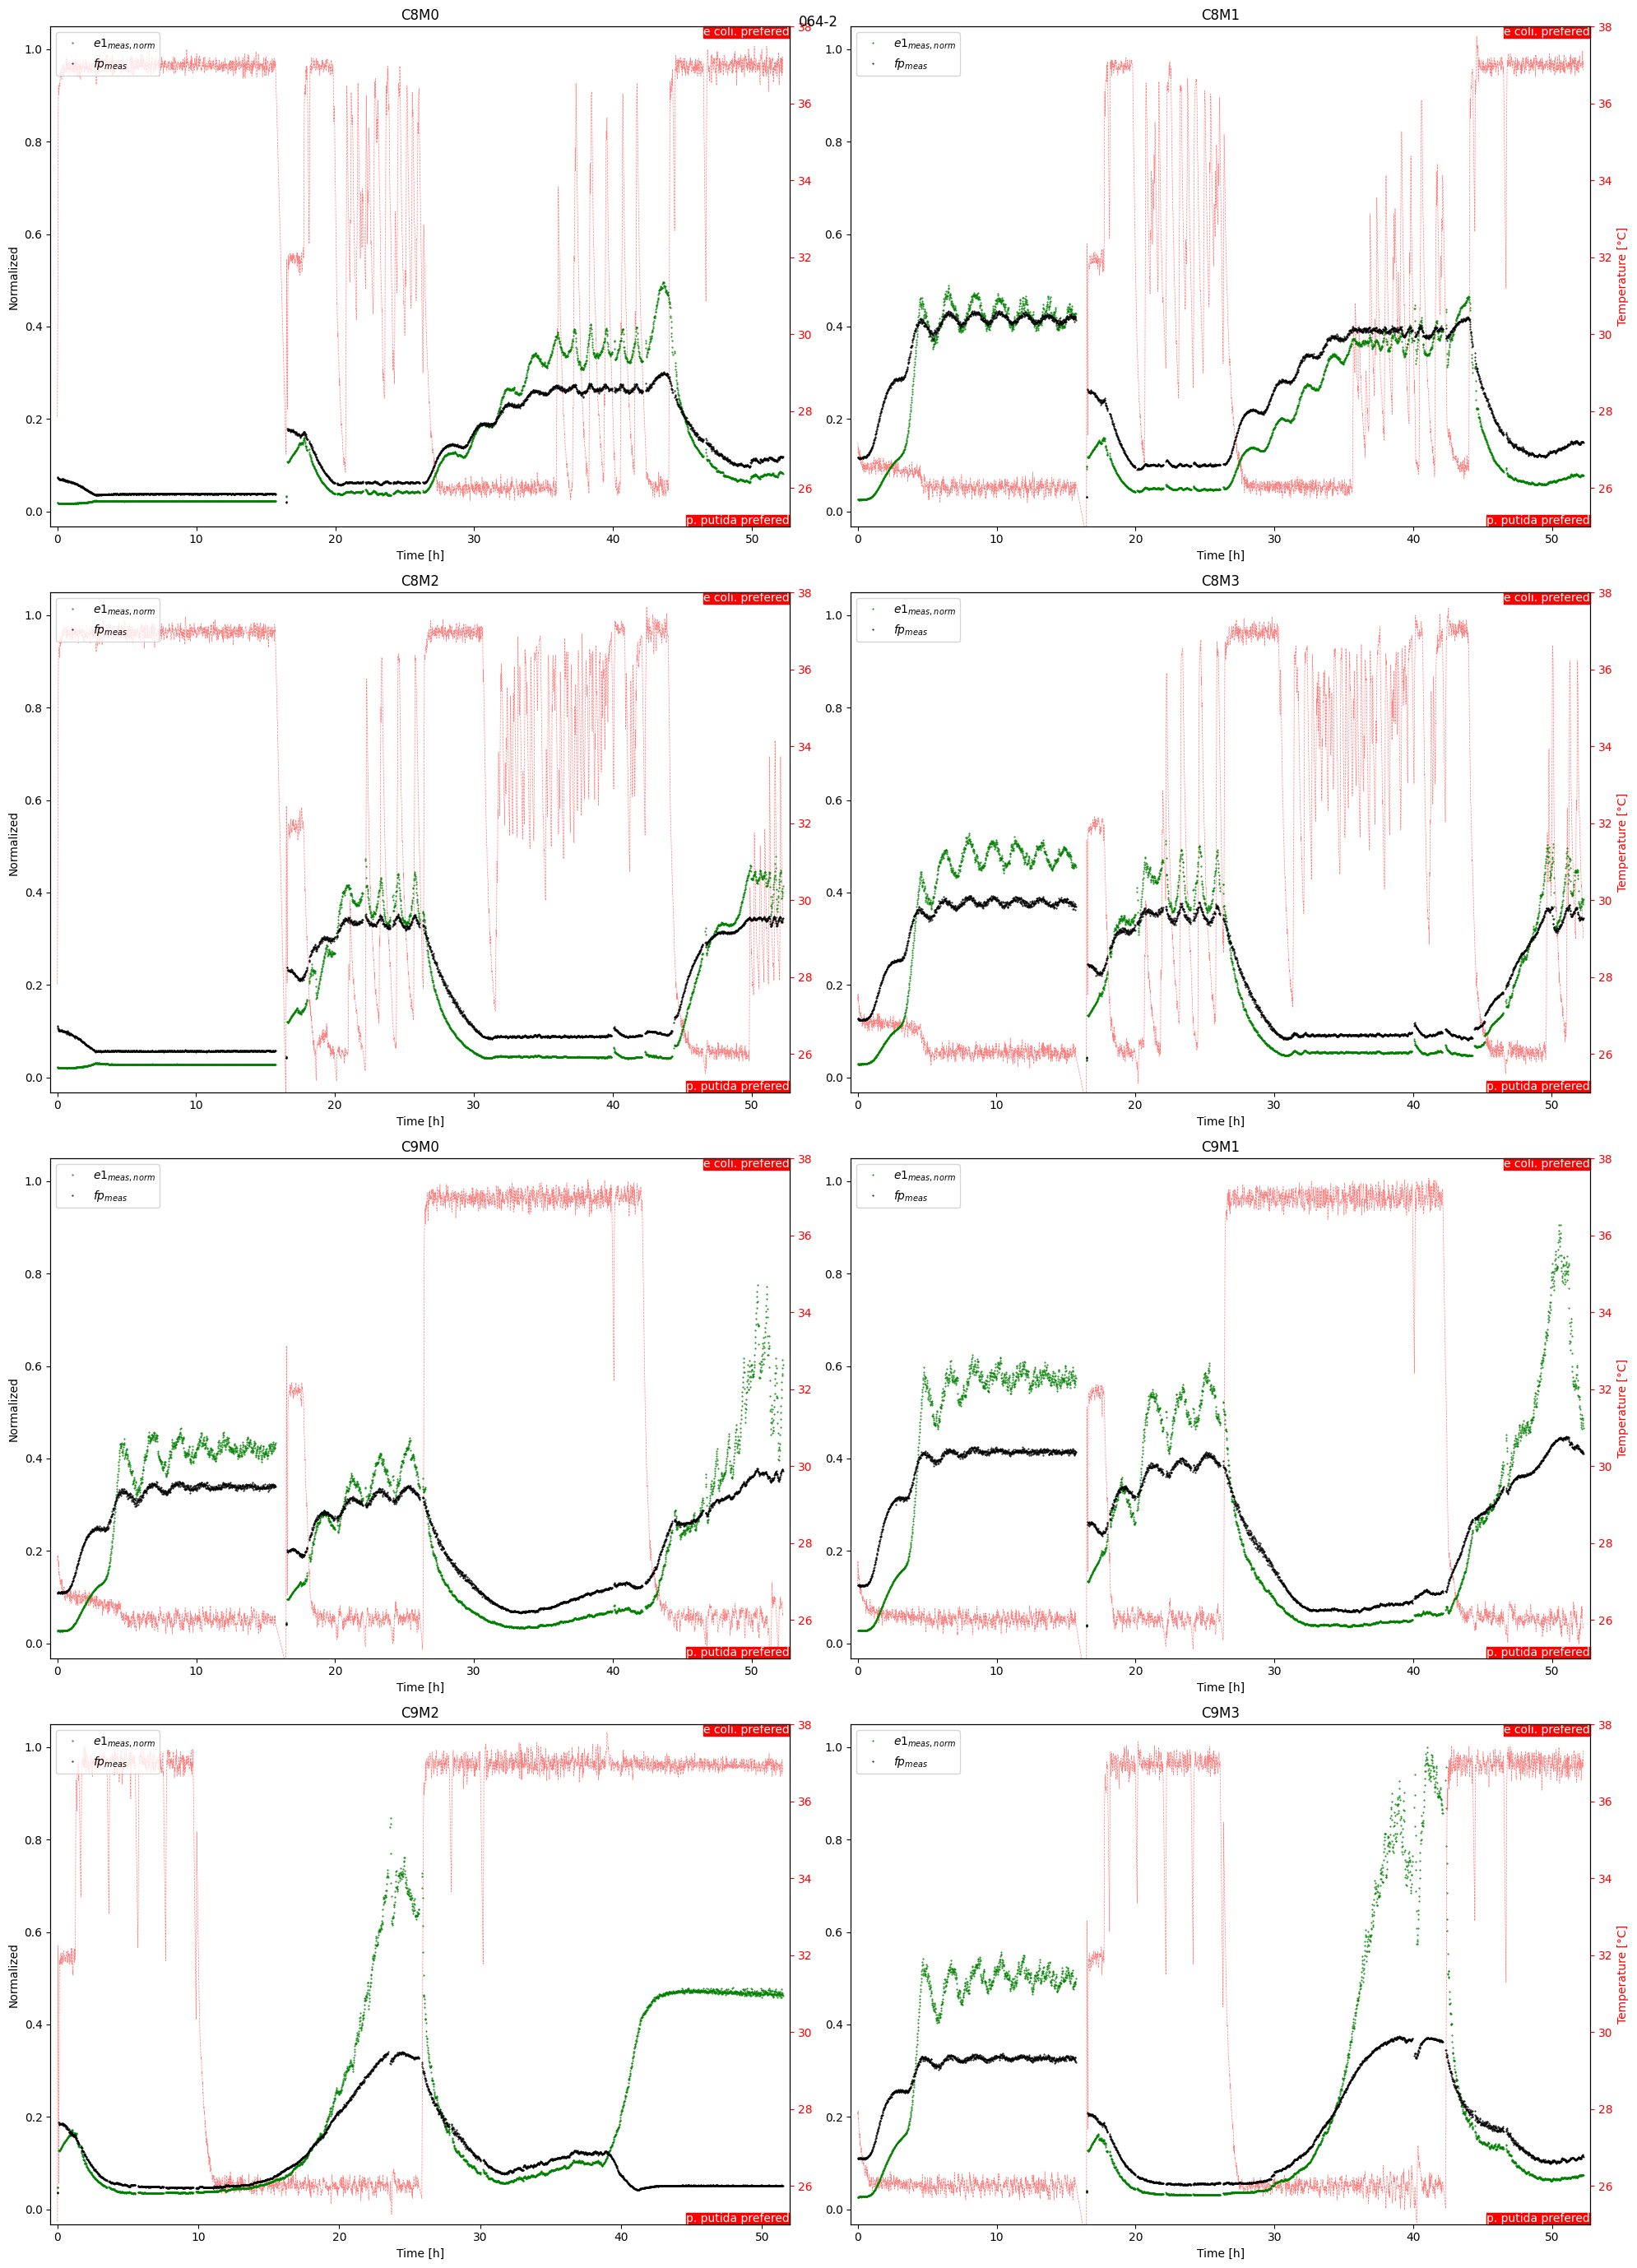

In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from run import CbData
from paramsData import CbDataParam
from params import Params
import os

# SPECIFY DATA
data_name = '064-2'
cbParam = CbDataParam(data_name)
cbParam.sampcycle = np.array([[0,3000] for i in range(cbParam.n_reactors)])
cbData = CbData(cbParam.path, cbParam.file_ind, cbParam.sampcycle, cbParam.n_reactors)

parameters = Params().default

# ANALYSIS
# cbParam.n_reactors = 1
b1_max = max(max(cbData.b1[j]) for j in range(cbParam.n_reactors))
e1_max = max(max(cbData.b1[j]*cbData.fl[j]) for j in range(cbParam.n_reactors))
n_rows = math.ceil(cbParam.n_reactors/2)
n_culumns = 2 if cbParam.n_reactors > 1 else 1
matplotlib.style.use('default')
fig, ax = plt.subplots(n_rows,n_culumns,sharey='all')
fig.set_figheight(n_rows*7)
fig.set_figwidth(n_culumns*10)
if n_culumns == 1:
    ax = [ax]
if n_rows == 1:
    ax = [ax]
for j in range(cbParam.n_reactors):
    r = j//2
    c = j%2
    # j = 1

    axr = ax[r][c].twinx()
    ax[r][c].set_zorder(2)
    axr.set_zorder(1)
    ax[r][c].patch.set_visible(False)

    axr.plot(cbData.time_h[j],cbData.temp[j],'--r',lw=0.5, alpha=0.5)
    # axr.plot(cbData.time_h[j],cbData.temp_sp[j],'r',lw=0.5, alpha=1, label = 'temp_sp')
    # axr.plot(cbData.time_h[j],cbData.temp_ext[j],'b',lw=0.5, alpha=1, label = 'temp_ext')
    # axr.plot(cbData.time_h[j],cbData.temp_int[j],'m',lw=0.5, alpha=1, label = 'temp_int')
    # ax[r][c].plot(cbData.time_h[j],cbData.hr[j]*100,'k',lw=0.5, alpha=0.5, label = '$hr_{meas}*100$')
    ax[r][c].plot(cbData.time_h[j],cbData.fl[j]*cbData.b1[j]/e1_max,'.g',markersize = 1, label = '$e1_{meas,norm}$')
    # ax[r][c].plot(cbData.time_h[j],cbData.b1[j]/b1_max,'.b',markersize = 1, label = '$b1_{meas,norm}$')
    ax[r][c].plot(cbData.time_h[j],cbData.fl[j],'.k',markersize = 1, alpha = 1, label = '$fp_{meas}$')
    
    ax[r][c].legend(loc="upper left")
    # axr.legend(loc="upper right")
    if (j%2 == 0):
        ax[r][c].set_ylabel("Normalized")
    else:
        axr.set_ylabel('Temperature [°C]', color='r')
        ax[r][c].tick_params(axis='y', labelleft=True)
    axr.tick_params(axis='y', color='r', labelcolor='r')
    axr.text(1, 1, 'e coli. prefered',
            horizontalalignment='right',
            verticalalignment='top',
            transform=axr.transAxes,
            color='w',
            bbox={'facecolor': 'red', 'alpha': 1, 'pad': 0, 'edgecolor': 'r'})
    axr.text(1, 0, 'p. putida prefered',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=axr.transAxes,
            color='w',
            bbox={'facecolor': 'red', 'alpha': 1, 'pad': 0, 'edgecolor': 'r'})
    ax[r][c].set_xlabel("Time [h]")
    ax[r][c].set_xlim([cbData.time_h[j][0]-0.5,cbData.time_h[j][-1]+0.5])
    # ax[r][c].set_ylim([-5,105])
    axr.set_ylim([25,38])
    ax[r][c].set_title(cbParam.titles[j])
# TODO: Set titles
fig.suptitle(data_name)
fig.tight_layout()
results_dir = "Images/{}".format(data_name)
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir+"/analysis_fl.png")

cb_fc_ec information of 051-1 not given.


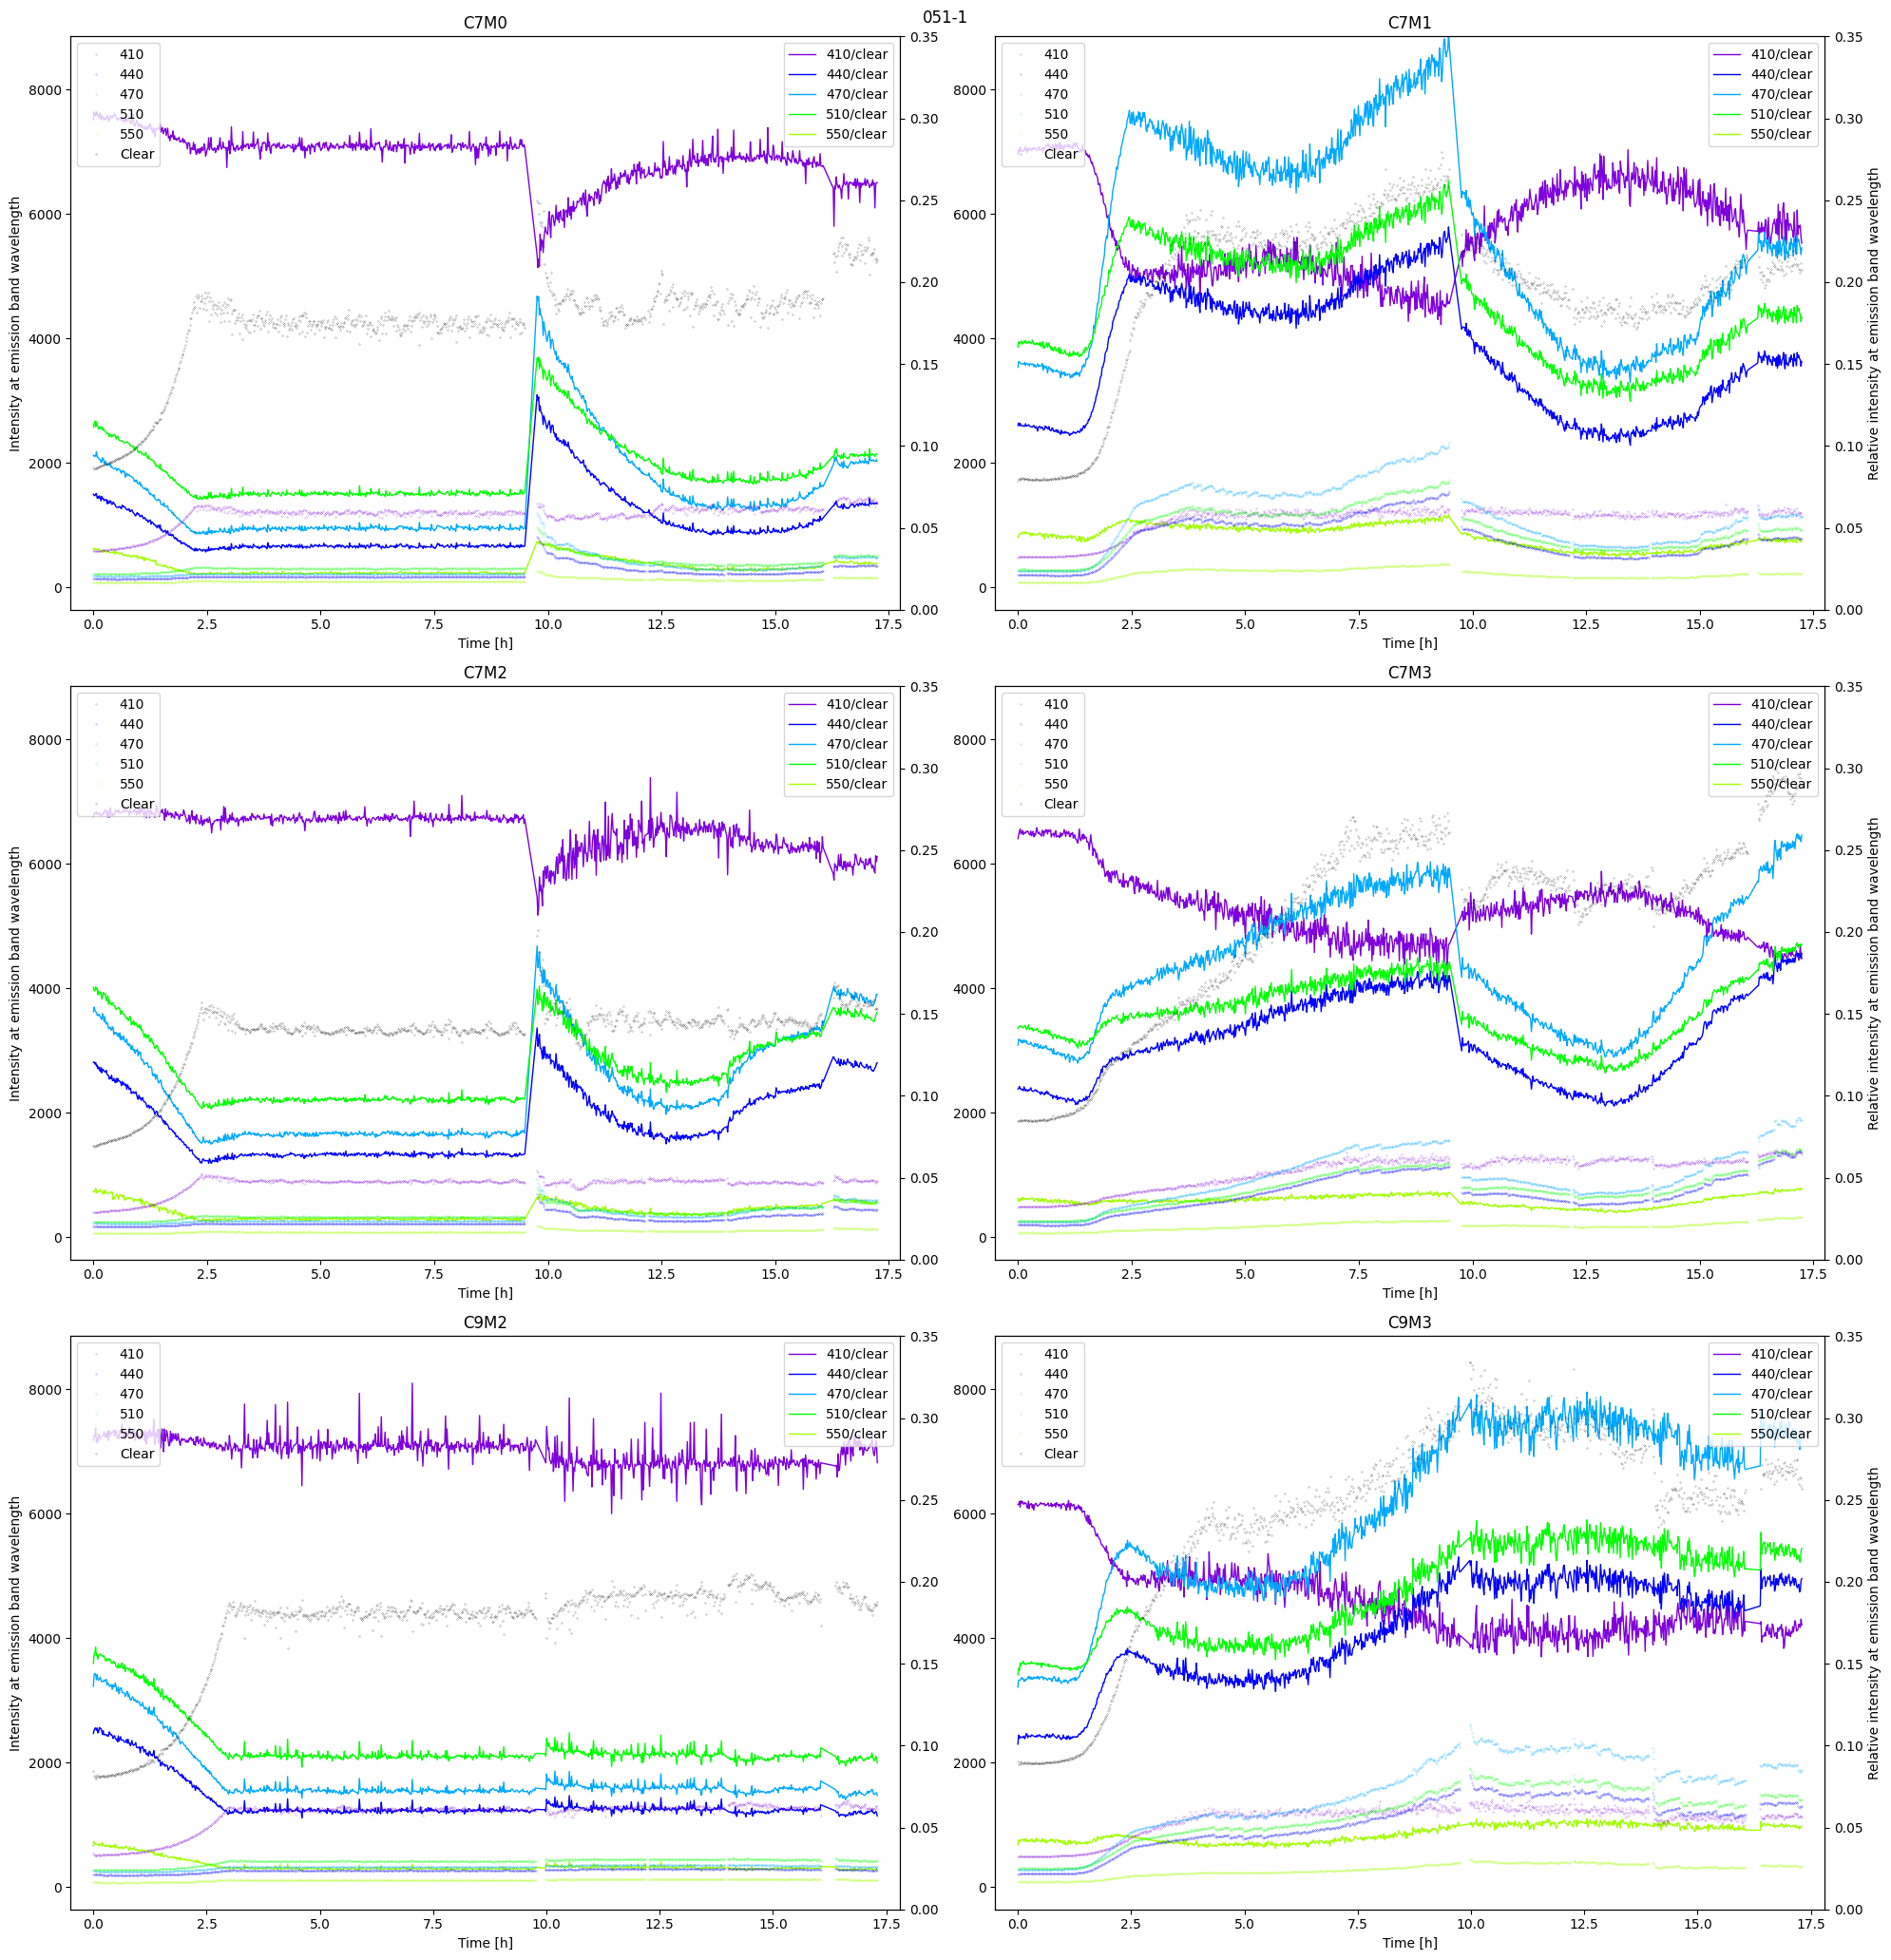

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from paramsData import CbDataParam
from params import Params
import os
import glob
import pandas as pd

class CbData:
    def __init__(self, path, file_ind, scope, n_reactors):
        cb_files = sorted(glob.glob(path + "/*.csv"))
        cb_dfs = []
        for i in file_ind:
            df = pd.read_csv(cb_files[i], index_col=None, header=0)
            cb_dfs.append(df)

        self.time, self.time_h, self.temp = [], [], []
        self.a410, self.a440, self.a470, self.a510, self.a550, self.aClear = [], [], [], [], [], []
        for j in range(n_reactors):
            time = cb_dfs[j]["exp_time"][scope[j][0]:scope[j][-1]+1].to_numpy()
            self.time.append(time-time[0])
            self.time_h.append(self.time[j]/3600)
            self.temp.append(cb_dfs[j]["media_temp"][scope[j][0]:scope[j][-1]+1].to_numpy())
            if (j < 4):
                self.a410.append(cb_dfs[j]["LEDA_410"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a440.append(cb_dfs[j]["LEDA_440"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a470.append(cb_dfs[j]["LEDA_470"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a510.append(cb_dfs[j]["LEDA_510"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a550.append(cb_dfs[j]["LEDA_550"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.aClear.append(cb_dfs[j]["LEDA_CLEAR"][scope[j][0]:scope[j][-1]+1].to_numpy())
            else:
                self.a410.append(cb_dfs[j]["Em_nm410_Ex_LEDA"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a440.append(cb_dfs[j]["Em_nm440_Ex_LEDA"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a470.append(cb_dfs[j]["Em_nm470_Ex_LEDA"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a510.append(cb_dfs[j]["Em_nm510_Ex_LEDA"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.a550.append(cb_dfs[j]["Em_nm550_Ex_LEDA"][scope[j][0]:scope[j][-1]+1].to_numpy())
                self.aClear.append(cb_dfs[j]["Em_CLEAR_Ex_LEDA"][scope[j][0]:scope[j][-1]+1].to_numpy())
            

# SPECIFY DATA
data_name = '051-1'
cbParam = CbDataParam(data_name)
cbData = CbData(cbParam.path, cbParam.file_ind, cbParam.sampcycle, cbParam.n_reactors)

# ANALYSIS
# cbParam.n_reactors = 1
n_rows = math.ceil(cbParam.n_reactors/2)
n_culumns = 2 if cbParam.n_reactors > 1 else 1
matplotlib.style.use('default')
fig, ax = plt.subplots(n_rows,n_culumns,sharey='all')
fig.set_figheight(n_rows*7)
fig.set_figwidth(n_culumns*10)
if n_culumns == 1:
    ax = [ax]
if n_rows == 1:
    ax = [ax]
for j in range(cbParam.n_reactors):
    r = j//2
    c = j%2
    # j = 1

    axr = ax[r][c].twinx()
    ax[r][c].set_zorder(2)
    axr.set_zorder(1)
    ax[r][c].patch.set_visible(False)

    # axr.plot(cbData.time_h[j],cbData.temp[j],'--r',lw=0.5, alpha=0.5)
    axr.plot(cbData.time_h[j],cbData.a410[j]/cbData.aClear[j],color='#7e00db',lw=1, alpha=1, label = '410/clear')
    axr.plot(cbData.time_h[j],cbData.a440[j]/cbData.aClear[j],color='#0000ff',lw=1, alpha=1, label = '440/clear')
    axr.plot(cbData.time_h[j],cbData.a470[j]/cbData.aClear[j],color='#00a9ff',lw=1, alpha=1, label = '470/clear')
    axr.plot(cbData.time_h[j],cbData.a510[j]/cbData.aClear[j],color='#00ff00',lw=1, alpha=1, label = '510/clear')
    axr.plot(cbData.time_h[j],cbData.a550[j]/cbData.aClear[j],color='#a3ff00',lw=1, alpha=1, label = '550/clear')

    ax[r][c].plot(cbData.time_h[j],cbData.a410[j],'.',color='#7e00db',markersize=.3, alpha=1, label = '410')
    ax[r][c].plot(cbData.time_h[j],cbData.a440[j],'.',color='#0000ff',markersize=.3, alpha=1, label = '440')
    ax[r][c].plot(cbData.time_h[j],cbData.a470[j],'.',color='#00a9ff',markersize=.3, alpha=1, label = '470')
    ax[r][c].plot(cbData.time_h[j],cbData.a510[j],'.',color='#00ff00',markersize=.3, alpha=1, label = '510')
    ax[r][c].plot(cbData.time_h[j],cbData.a550[j],'.',color='#a3ff00',markersize=.3, alpha=1, label = '550')
    ax[r][c].plot(cbData.time_h[j],cbData.aClear[j],'.k',markersize=.3, alpha=1, label = 'Clear')

    ax[r][c].legend(loc="upper left")
    axr.legend(loc="upper right")
    if (j%2 == 0):
        ax[r][c].set_ylabel("Intensity at emission band wavelength")
    else:
        axr.set_ylabel('Relative intensity at emission band wavelength')
        ax[r][c].tick_params(axis='y', labelleft=True)
    # axr.tick_params(axis='y', color='r', labelcolor='r')
    # axr.text(1, 1, 'e coli. prefered',
    #         horizontalalignment='right',
    #         verticalalignment='top',
    #         transform=axr.transAxes,
    #         color='w',
    #         bbox={'facecolor': 'red', 'alpha': 1, 'pad': 0, 'edgecolor': 'r'})
    # axr.text(1, 0, 'p. putida prefered',
    #         horizontalalignment='right',
    #         verticalalignment='bottom',
    #         transform=axr.transAxes,
    #         color='w',
    #         bbox={'facecolor': 'red', 'alpha': 1, 'pad': 0, 'edgecolor': 'r'})
    ax[r][c].set_xlabel("Time [h]")
    ax[r][c].set_xlim([cbData.time_h[j][0]-0.5,cbData.time_h[j][-1]+0.5])
    axr.set_ylim([0,0.35])
    # axr.set_ylim([25,38])
    ax[r][c].set_title(cbParam.titles[j])
# TODO: Set titles
fig.suptitle(data_name)
fig.tight_layout()
results_dir = "Images/{}".format(data_name)
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
fig.savefig(results_dir+"/analysis_fl.png")